In [1]:
import random

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T

from lib.utils.dataset import SequenceTyphoonDataset as STD

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

labels_ = ["pressure",]
# labels_ = ["pressure", "month", "day", "hour", "lat", "lng"]

if "grade" in labels_:
    def filter_func(x):
        return x.grade() < 7
elif "pressure" in labels_:
    def filter_func(x):
        return x.grade() < 6

dataset = STD(labels=labels_,
              preprocessed_path="r34p_10k_w6",
              latent_dim=512,
              x=[0,-1],
              y=[0],
              num_inputs=3,
              num_preds=8,
              interval=3,
              #filter_func= lambda x: x.grade() < 6,
              filter_func=filter_func,
              output_all=True,
              pred_diff=False)

train, val, test = dataset.random_split([0.7, 0.15, 0.15], split_by="sequence")

print(f"\n{len(train)} train sequences")
print(f"{len(val)} val sequences")
print(f"{len(test)} test sequences")

test_loader = DataLoader(test,
                        batch_size=1,
                        shuffle=False,
                        num_workers=0,
                        collate_fn=lambda x:x)
print(len(test_loader))


Expected model inputs: 513
Expected model outputs: 1

[652, 139, 139] 930
930

652 train sequences
139 val sequences
139 test sequences
139


In [3]:
from lib.models.lstm_predictor import LSTM


def _load_checkpoint(model, path):
    data = torch.load(path)
    model.load_state_dict(data["model_dict"])

    print("="*100)
    print(f"Loading model from checkpoint {path}")
    print("="*100)

    return model

model = LSTM(
    test_loader.dataset.dataset.get_input_size(),
    hidden_size=1024,
    num_layers=3,
    output_size=test_loader.dataset.dataset.num_preds
)

model = _load_checkpoint(model, "weights/ts/lstm_10kp_3l_1024_3i_multi_pressure/checkpoint_3000.pth")
model = model.eval()

device = "cuda:0"
model = model.to(device)


Loading model from checkpoint weights/ts/lstm_10kp_3l_1024_3i_multi_pressure/checkpoint_3000.pth


In [4]:
loader=iter(test_loader)


In [5]:
from torch.nn.functional import sigmoid

from lib.utils.dataset import NORMALIZATION


@torch.no_grad()
def predict_es_transition(model, sequence, start, device):
    if isinstance(sequence, tuple):
        images, labels = sequence
        inputs = images[test_loader.dataset.dataset.slice_inputs(start)]
        outputs = labels[test_loader.dataset.dataset.slice_outputs(start), test_loader.dataset.dataset.y]
    else:
        inputs = sequence[test_loader.dataset.dataset.slice_inputs(start), test_loader.dataset.dataset.x]
        outputs = sequence[test_loader.dataset.dataset.slice_outputs(start), test_loader.dataset.dataset.y]

    prediction = sigmoid(model(inputs.unsqueeze(0).to(device)))[-1]

    return prediction.cpu().item(), (outputs[-1]==6).float().item()


def pressure(x):
    return x * NORMALIZATION["pressure"][1] + NORMALIZATION["pressure"][0]

@torch.no_grad()
def predict_pressure(model, sequence, start, device, pred_diff):
    if isinstance(sequence, tuple):
        images, labels = sequence
        inputs = images[test_loader.dataset.dataset.slice_inputs(start)]
        outputs = labels[test_loader.dataset.dataset.slice_outputs(start), test_loader.dataset.dataset.y]
    else:
        inputs = sequence[test_loader.dataset.dataset.slice_inputs(start), test_loader.dataset.dataset.x]
        outputs = sequence[test_loader.dataset.dataset.slice_outputs(start), test_loader.dataset.dataset.y]

    prediction = model(inputs.unsqueeze(0).to(device))
    if pred_diff:
        prediction += sequence[test_loader.dataset.dataset.slice_inputs(start), test_loader.dataset.dataset.y][-1].item()

    return pressure(prediction[-1].cpu().item()), pressure(outputs[-1].item())


def smooth_ema(predictions, alpha=0.9):
    last = predictions[0]
    smoothed = []
    for p in predictions:
        smoothed.append(alpha*p + (1-alpha)*last)
        last = smoothed[-1]
    return smoothed

### Animation (GIF) of evolution of forecasting depending on input images

In [25]:
# Select which sequence to fetch to create output animation

labels, seq_id = dataset.get_sequence("202302")

print(labels.shape)

torch.Size([342, 513])


202302


100%|██████████| 309/309 [00:00<00:00, 676.83it/s]


13.019816917091948


  0%|          | 0/309 [00:00<?, ?it/s]/tmp/ipykernel_233097/2007559654.py:34: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  return Image.frombytes("RGB", fig.canvas.get_width_height(),fig.canvas.renderer.tostring_rgb())
100%|██████████| 309/309 [00:28<00:00, 10.71it/s]


GIF saved in: gifs/202302.gif


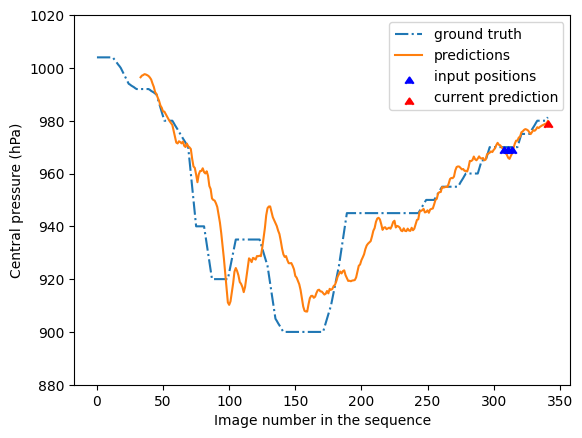

In [26]:
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageOps
from sklearn.metrics import root_mean_squared_error
from tqdm import tqdm
from os import makedirs


def get_concat_h(im1, im2):
    im2 = ImageOps.contain(im2, (im1.width, im1.width))
    h, w = im1.width, im1.height + im2.height
    dst = Image.new("RGB", (h,w))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst#.resize((int(h/2), int(w/2)))


def get_plot(x, gt, preds, i):
    plt.clf()
    plt.plot(x, gt, "-.", label="ground truth", zorder=0)
    plt.plot(x, preds, label="predictions", zorder=5)

    # Hightlight inputs
    plt.scatter(x[dataset.slice_inputs(i)], gt[dataset.slice_inputs(i)], marker=6, color="b", label="input positions", zorder=10)
    # Hightlight prediction
    plt.scatter(x[i+33], preds[i+33], marker=6, color="r", label="current prediction", zorder=10)

    plt.ylim(880, 1020)
    plt.xlabel("Image number in the sequence")
    plt.ylabel("Central pressure (hPa)")
    plt.legend()

    fig = plt.gcf()
    fig.canvas.draw()
    return Image.frombytes("RGB", fig.canvas.get_width_height(),fig.canvas.renderer.tostring_rgb())


# images, labels, seq_id = next(loader)[0]
# labels, seq_id = next(loader)[0]
print(seq_id)
data = []

pred_window = (3 + 8)*test_loader.dataset.dataset.interval

images = test_loader.dataset.dataset.get_sequence_images(seq_id)
triggers = []
font = ImageFont.truetype("arial.ttf", 20)

for i in tqdm(range(len(labels) - pred_window)):
    if "grade" in labels_:
        prediction, gt = predict_es_transition(model, labels, i, device)
        # prediction, gt = predict_es_transition(model, (images, labels), i, device)
    elif "pressure" in labels_:
        prediction, gt = predict_pressure(model, labels, i, device, dataset.pred_diff)

    input_images = images[test_loader.dataset.dataset.slice_inputs(i)]
    triggers.append(np.concatenate([image for image in input_images], axis=1))

    data.append((prediction, gt))

gif = []
mn = np.min(triggers)
mx = np.max(triggers)
for i in range(len(triggers)):
    im = Image.fromarray(255 * (triggers[i] - mn) / (mx - mn)).convert("RGB")
    draw = ImageDraw.Draw(im)
    prediction, gt = data[i]
    draw.text((0, 0), f"pred={int(prediction)}",fill="red", font=font)
    draw.text((0, 20), f"gt={int(gt)}",fill="red", font=font)
    draw.text((0, 40), f"{i}/{len(triggers)}",fill="red", font=font)
    draw.text((5, 199), "t-6",fill="red", font=font)
    draw.text((229, 199), "t-3",fill="red", font=font)
    draw.text((453, 199), "t",fill="red", font=font)

    gif.append(im)


preds, gt = zip(*data)
preds = smooth_ema(preds, 0.5)
#gt = (torch.Tensor(gt) == 6).float()
#print(f1_score(gt, np.round(preds)))
rmse = root_mean_squared_error(gt, preds)
print(rmse)

preds = [None]*pred_window + list(preds)

if "grade" in labels_:
    gt = (labels[:pred_window, test_loader.dataset.dataset.y]==6).float().squeeze().tolist() + list(gt)
elif "pressure" in labels_:
    gt = pressure(labels[:pred_window, test_loader.dataset.dataset.y].float().squeeze()).tolist() + list(gt)
x = list(range(len(gt)))


for i in tqdm(range(len(gif))):
    gif[i] = get_concat_h(gif[i], get_plot(x, gt, preds, i))

makedirs("gifs", exist_ok=True)

gif[0].save(f"gifs/{seq_id}.gif",
            save_all=True,
            append_images=gif[1:],
            optimize=False, duration=150, loop=200)

print(f"GIF saved in: gifs/{seq_id}.gif")

In [ ]:
from os import makedirs

from sklearn.metrics import balanced_accuracy_score, f1_score, root_mean_squared_error
from tqdm import tqdm

pred_window = (3 + 8)*test_loader.dataset.dataset.interval

all_preds = []
all_gt = []

results = []

path = "images/lstm_10kp_pressure"
makedirs(path, exist_ok=True)

for i, labels in enumerate(tqdm(test_loader)):
    # images, labels, seq_id = labels[0]
    labels, seq_id = labels[0]
    data = []

    for j in range(len(labels) - pred_window):
        if "grade" in labels_:
            #data.append(predict_es_transition(model, (images, labels), j, device))
            data.append(predict_es_transition(model, labels, j, device))
        elif "pressure" in labels_:
            data.append(predict_pressure(model, labels, j, device, dataset.pred_diff))

    preds, gt = zip(*data)
    preds = smooth_ema(preds, 0.5)

    all_preds.extend(preds)
    all_gt.extend(gt)
    rmse = root_mean_squared_error(gt, preds)

    preds = [None]*pred_window + list(preds)
    if "grade" in labels_:
        gt = (labels[:pred_window, test_loader.dataset.dataset.y]==6).float().squeeze().tolist() + list(gt)
    elif "pressure" in labels_:
        gt = pressure(labels[:pred_window, test_loader.dataset.dataset.y].float().squeeze()).tolist() + list(gt)

    x = list(range(len(gt)))
    plt.clf()
    plt.plot(x, gt, "-.", label="ground truth")
    plt.plot(x, preds, label="predictions")
    plt.ylim(-0.1, 1.1)
    #plt.ylim(880, 1020)
    plt.legend()
    plt.title(f"Test Sequence {seq_id}, rmse: {rmse:.3f}")
    plt.xlabel("Sequence frame number")
    plt.savefig(f"{path}/{seq_id}_{rmse:.3f}.png")

    results.append((seq_id, rmse))

# print(root_mean_squared_error(all_gt, all_preds))
# all_preds = np.round(all_preds)
# print(balanced_accuracy_score(all_gt, all_preds))
# print(f1_score(all_gt, all_preds))
print(root_mean_squared_error(all_gt, all_preds))
print(sorted(results, key=lambda x:x[1]))